In [25]:
from scipy.io import loadmat, savemat
import torch
import librosa
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from IPython.display import Audio

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT, entropy_loss, fast_sst, frequency_tracking, kurtosis_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
signal, sr = librosa.load('..//data/7.wav', sr=2_000)
x = torch.from_numpy(signal).float().to(device)[None, 15_000:70_000]
stride = 50; support = 1_500
print(sr, x.shape)

2000 torch.Size([1, 55000])


In [27]:
# specs = {} 
# stfts = {}
# wins = {}
# losses = {} 
# f_hats = {} 
# ss = {} 
# losses2 = {} 
# f_hats2 = {} 
# mse = {} 
# mse2 = {} 

# with open("../fig/5_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/5_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/5_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/5_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/5_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/5_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/5_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/5_f_hats2.pkl", "wb") as file: pickle.dump(f_hats2, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/5_mse.pkl", "wb") as file: pickle.dump(mse, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/5_mse2.pkl", "wb") as file: pickle.dump(mse2, file, pickle.HIGHEST_PROTOCOL)

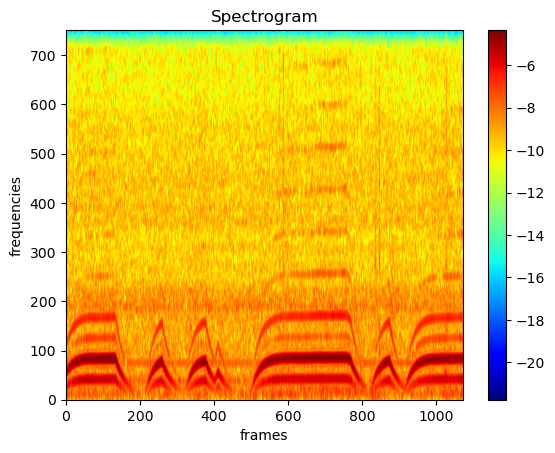

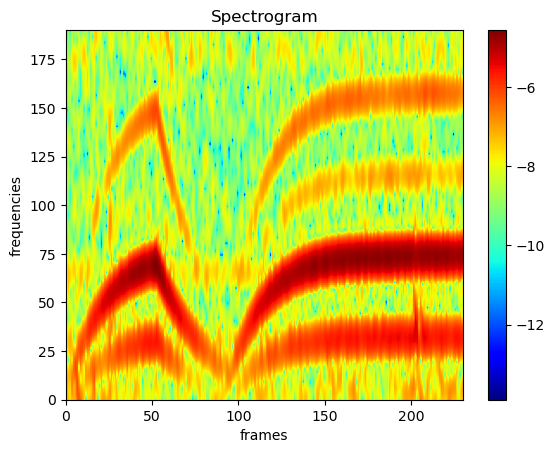

In [28]:
dstft = FDSTFT(x, win_length=200, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, *_ = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, 10:200, 820:1050], x, bar=True, wins=False, weights=False) 

with open("../fig/5_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['200'] = spec.detach().cpu()
with open("../fig/5_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['200'] = stft.detach().cpu()
with open("../fig/5_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['200'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/5_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['200'] = entropy_loss(spec).cpu().item()
with open("../fig/5_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

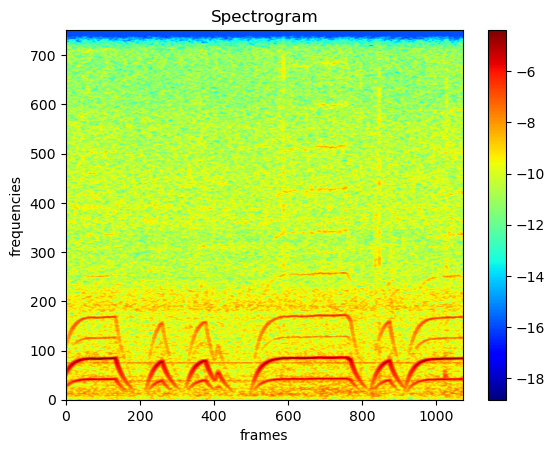

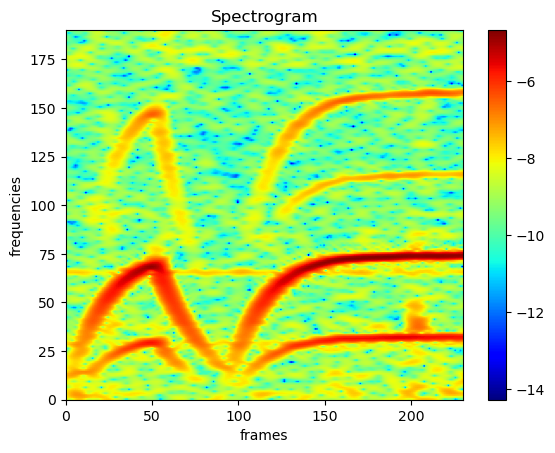

In [29]:
dstft = FDSTFT(x, win_length=1_000, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, 10:200, 820:1050], x, bar=True, wins=False, weights=False) 

with open("../fig/5_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['1000'] = spec.detach().cpu()
with open("../fig/5_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['1000'] = stft.detach().cpu()
with open("../fig/5_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['1000'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/5_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['1000'] = entropy_loss(spec).cpu().item()
with open("../fig/5_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Single window length

Epoch 00105: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00205: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00305: reducing learning rate of group 0 to 1.0000e-01.
304 478.9


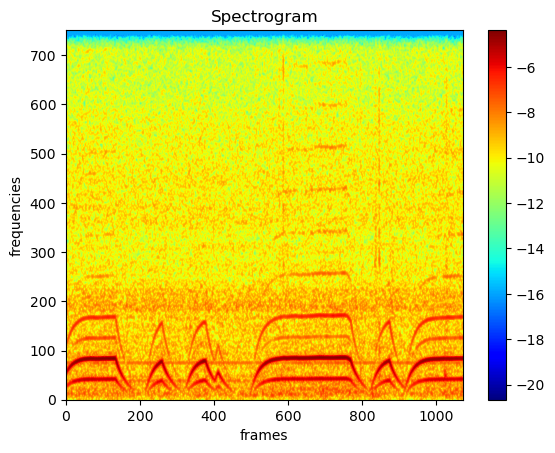

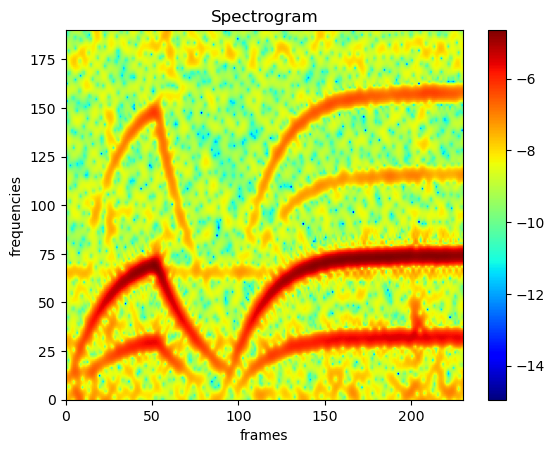

In [30]:
dstft = FDSTFT(x, win_length=877, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch, f'{dstft.win_length.item():.1f}')
dstft.print(spec, x, bar=True, wins=False, weights=False)
dstft.print(spec[:, 10:200, 820:1050], x, bar=True, wins=False, weights=False)

with open("../fig/5_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\theta$'] = spec.detach().cpu()
with open("../fig/5_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\theta$'] = stft.detach().cpu()
with open("../fig/5_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\theta$'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/5_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\theta$'] = entropy_loss(spec).detach().cpu().item()
with open("../fig/5_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)


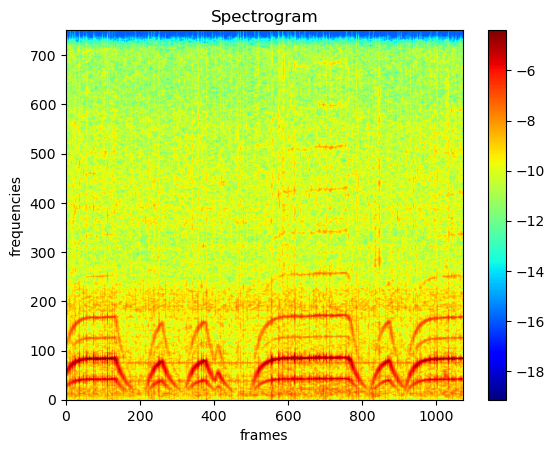

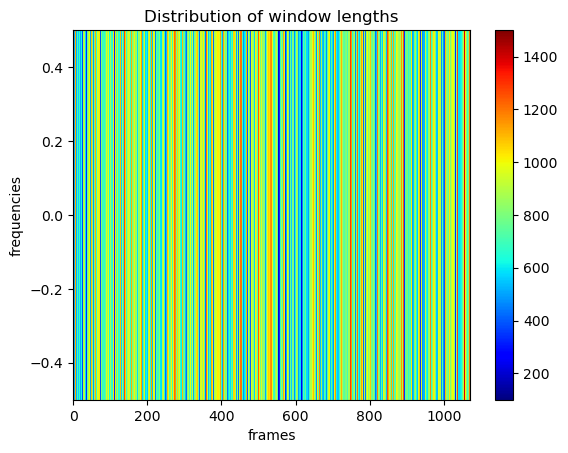

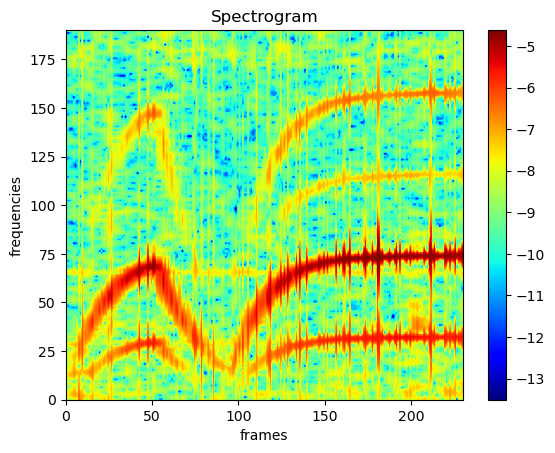

In [31]:
dstft = FDSTFT(x, win_length=877, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
dstft.win_length.data = dstft.win_min + (dstft.win_max - dstft.win_min) * torch.rand(dstft.win_length.size(), device=device)
spec, stft, *_ = dstft(x)
dstft.print(spec, wins=False, bar=True)
dstft.print(spec[:, 10:200, 820:1050], x, bar=True, wins=False, weights=False)

with open("../fig/5_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\mathcal{R}_t$'] = spec.detach().cpu()
with open("../fig/5_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\mathcal{R}_t$'] = stft.detach().cpu()
with open("../fig/5_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\mathcal{R}_t$'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/5_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\mathcal{R}_t$'] = entropy_loss(spec).detach().cpu().item()
with open("../fig/5_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Time-varying window length

Epoch 00189: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00289: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00389: reducing learning rate of group 0 to 1.0000e-01.
388


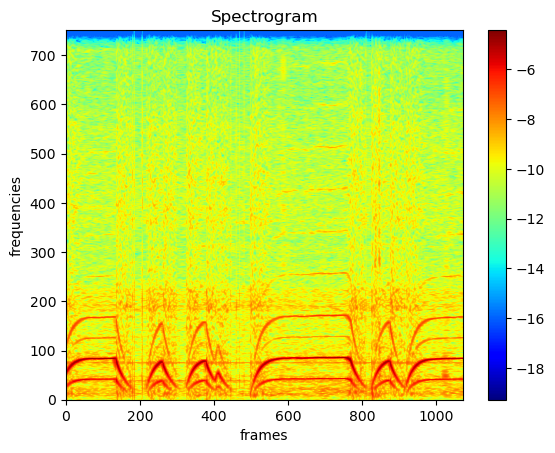

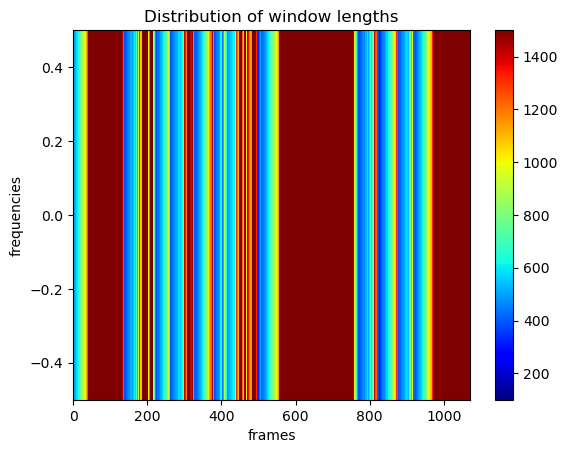

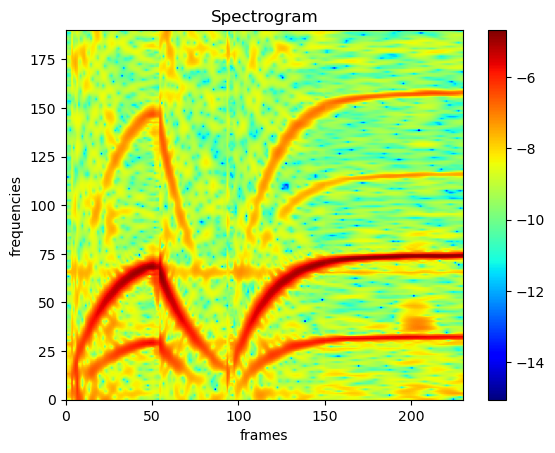

In [32]:
dstft = FDSTFT(x, win_length=277, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean() 
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 10:200, 820:1050], x, bar=True, wins=False, weights=False)

with open("../fig/5_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\theta_t$'] = spec.detach().cpu()
with open("../fig/5_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\theta_t$'] = stft.detach().cpu()
with open("../fig/5_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\theta_t$'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/5_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\theta_t$'] = entropy_loss(spec).detach().cpu().item()
with open("../fig/5_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Epoch 00212: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00481: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00644: reducing learning rate of group 0 to 1.0000e-01.
643


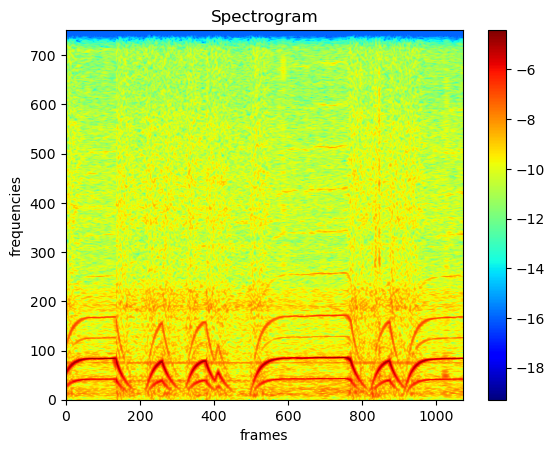

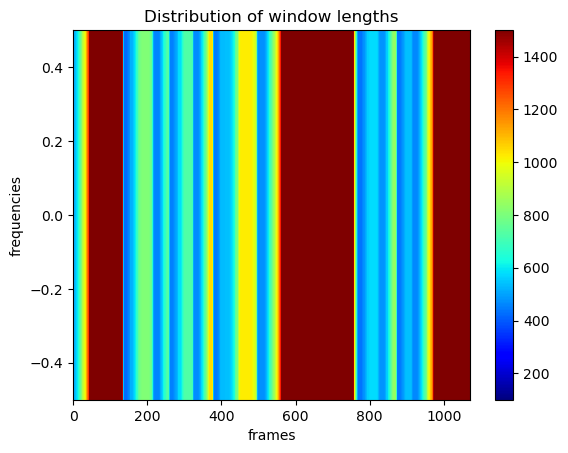

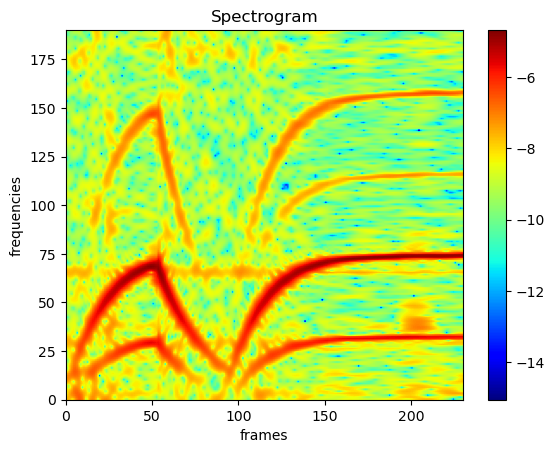

In [33]:
dstft = FDSTFT(x, win_length=777, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean() + 0.01 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 10:200, 820:1050], x, bar=True, wins=False, weights=False)

with open("../fig/5_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\tilde{\\theta}_t$'] = spec.detach().cpu()
with open("../fig/5_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\tilde{\\theta}_t$'] = stft.detach().cpu()
with open("../fig/5_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\tilde{\\theta}_t$'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/5_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\tilde{\\theta}_t$'] = entropy_loss(spec).detach().cpu().item()
with open("../fig/5_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Synchrosqueezing

In [34]:
with open("../fig/5_stfts.pkl", "rb") as file: stfts = pickle.load(file)
with open("../fig/5_ss.pkl", "rb") as file: ss = pickle.load(file)
with open("../fig/5_losses2.pkl", "rb") as file: losses2 = pickle.load(file)

for key, stft in stfts.items():
    z = fast_sst(stft[0], 10, stft.shape[-2], stft.shape[-1], .5, device)
    ss[key] = z
    losses2[key] = entropy_loss(z).detach().cpu()
    
with open("../fig/5_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
with open("../fig/5_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)

Loss

479


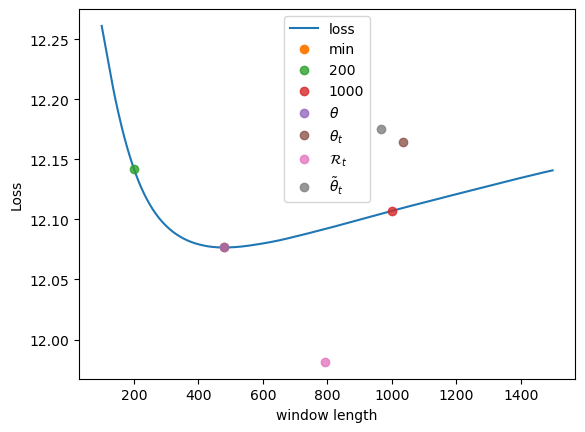

In [35]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses.items():
    plt.plot(wins[key], loss, 'o', alpha=.8, label=key)
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()

479


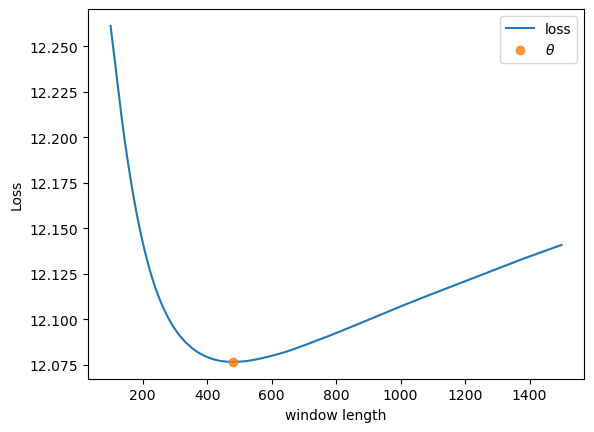

In [36]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')

with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
plt.plot(wins['$\\theta$'], losses['$\\theta$'], 'o', alpha=.8, label='$\\theta$')
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()

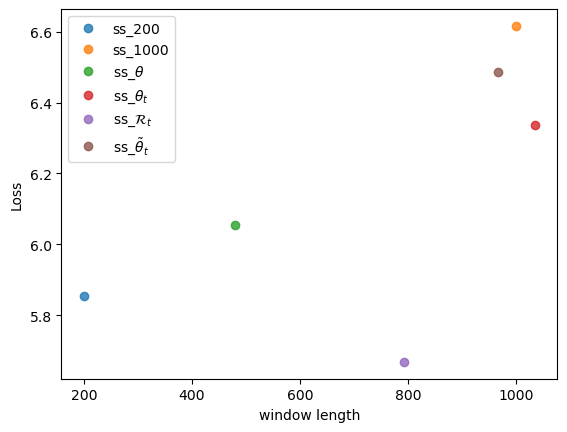

In [37]:
with open("../fig/5_losses2.pkl", "rb") as file: losses2 = pickle.load(file)
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses2.items(): plt.plot(wins[key], loss, 'o', alpha=.8, label=f'ss_{key}')
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()

479


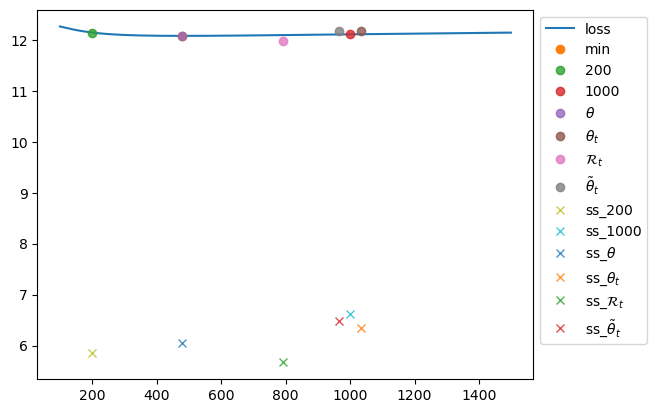

In [38]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../fig/5_losses2.pkl", "rb") as file: losses2 = pickle.load(file)
with open("../fig/5_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses.items(): plt.plot(wins[key], loss, 'o', alpha=.8, label=key)
for key, loss in losses2.items(): plt.plot(wins[key], loss, 'x', alpha=.8, label=f'ss_{key}')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

['200', '1000', '$\\theta$', '$\\theta_t$', '$\\mathcal{R}_t$', '$\\tilde{\\theta}_t$']
[12.142160415649414, 12.107139587402344, 12.076654434204102, 12.164361953735352, 11.981321334838867, 12.175081253051758]


(11.0, 12.783835315704346)

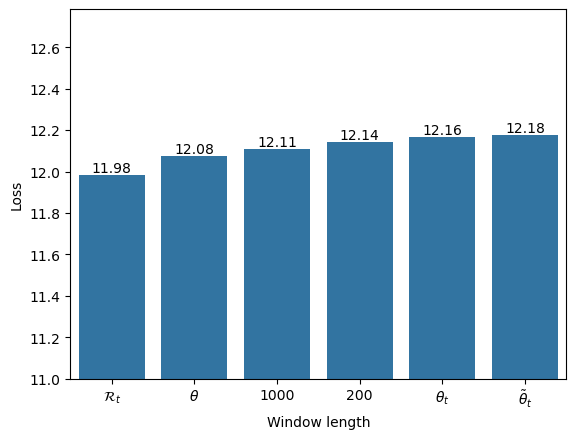

In [39]:
keys = ['$\\theta$', 'random', 't2']
with open("../fig/5_losses.pkl", "rb") as file: losses = pickle.load(file)
keys = list(losses.keys())
values = list(losses.values())
print(keys)
print(values)
df = pd.DataFrame({"Window length":keys, "Loss":values})

df.sort_values(by="Loss", axis=0, inplace=True)
df.head()
ax = sns.barplot(y='Loss', data=df, x="Window length")
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2f'); 
ax.set_ylim(11)

Plot SS

200


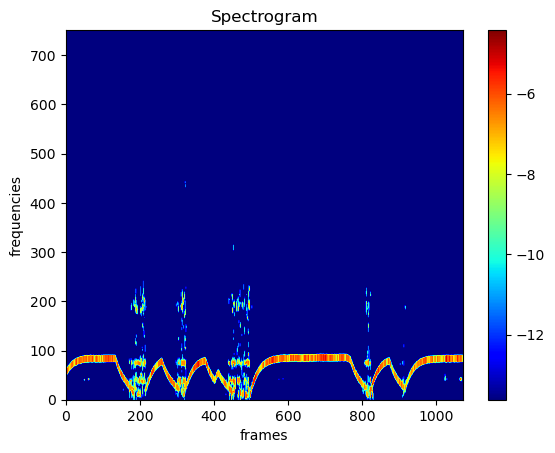

1000


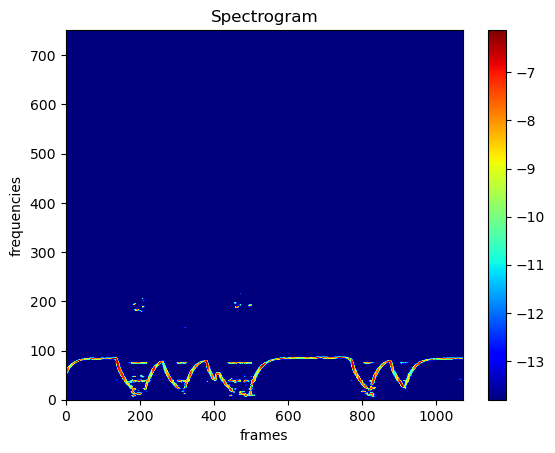

$\theta$


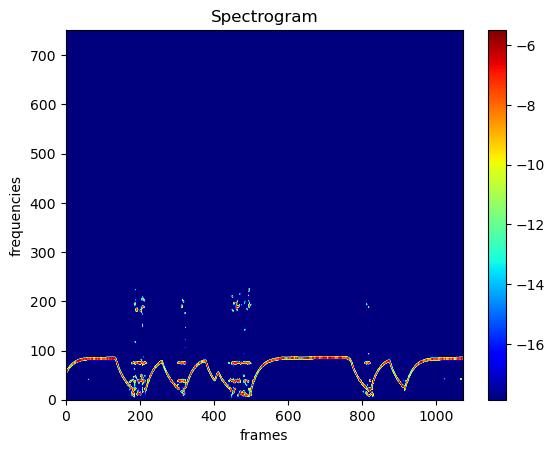

$\theta_t$


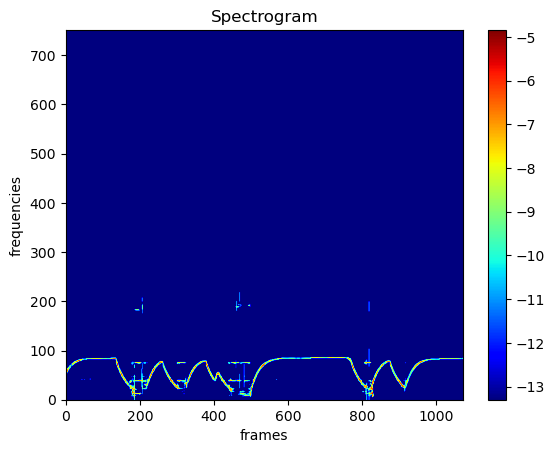

$\mathcal{R}_t$


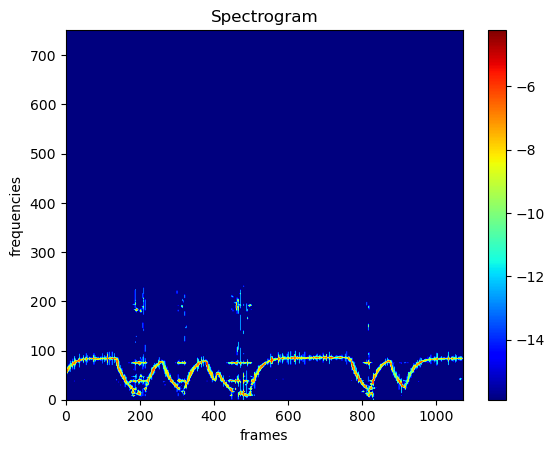

$\tilde{\theta}_t$


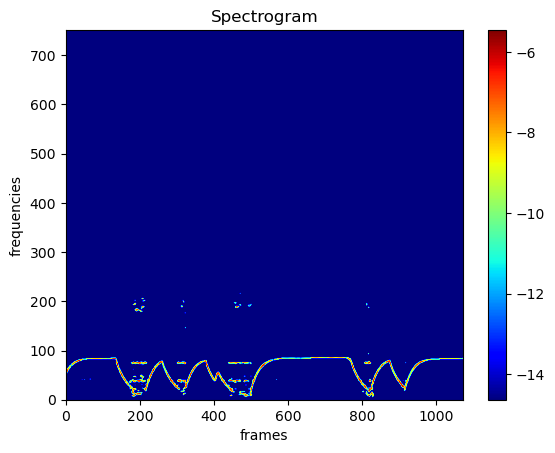

In [40]:
with open("../fig/5_ss.pkl", "rb") as file: ss = pickle.load(file)
for key, z in ss.items(): print(key); dstft.print(z[None, ...], x, bar=True, wins=False, weights=False)

200


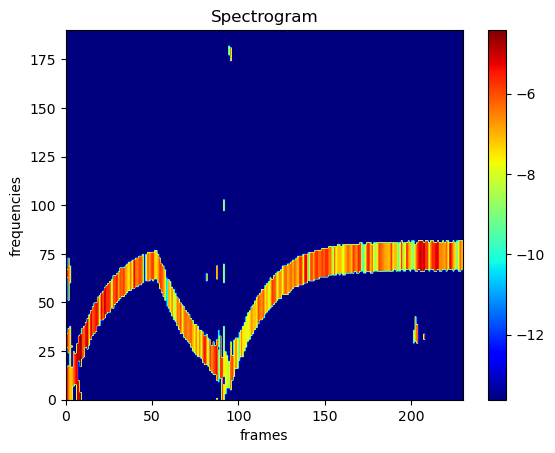

1000


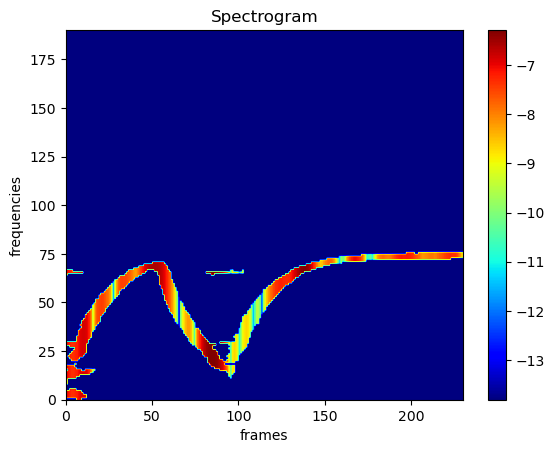

$\theta$


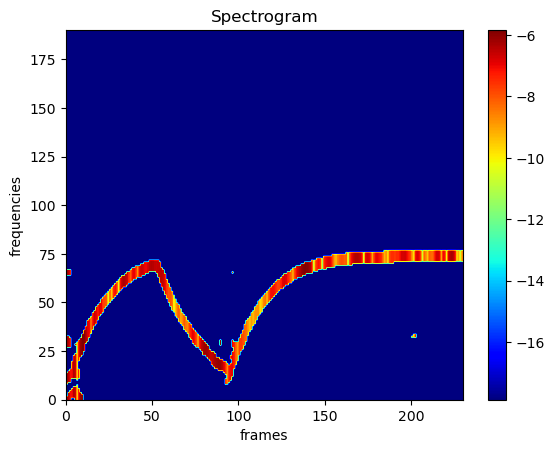

$\theta_t$


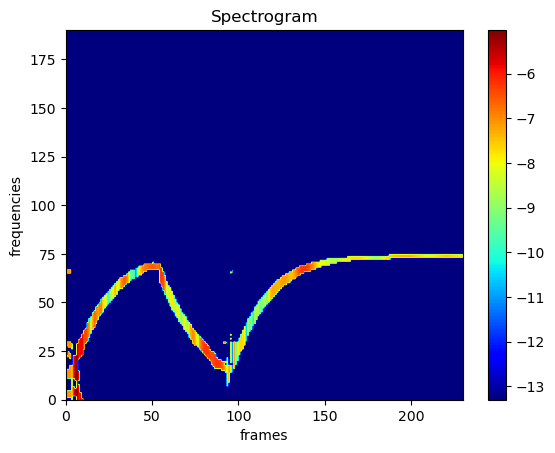

$\mathcal{R}_t$


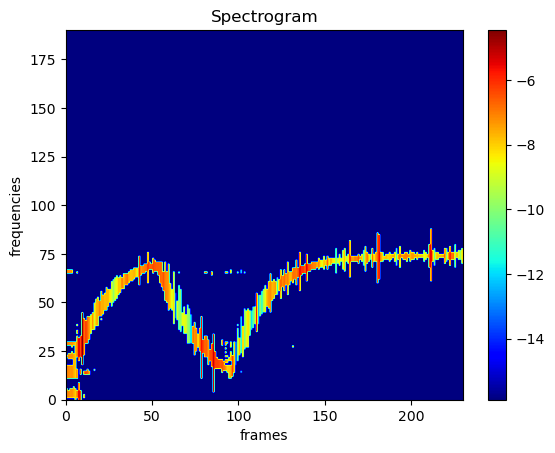

$\tilde{\theta}_t$


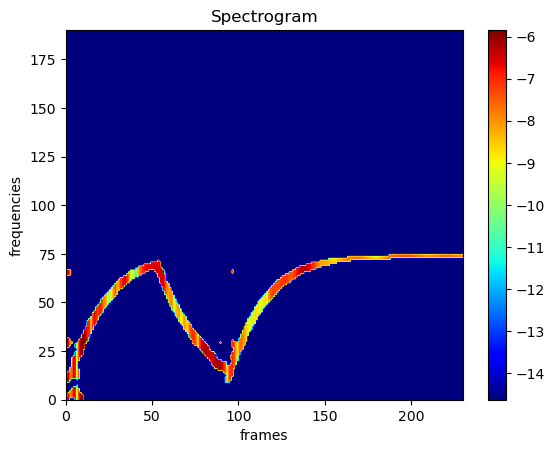

In [41]:
with open("../fig/5_ss.pkl", "rb") as file: ss = pickle.load(file)
for key, z in ss.items(): print(key); dstft.print(z[None, 10:200, 820:1050], x, bar=True, wins=False, weights=False)

$\hat{f}$

In [42]:
with open("../fig/5_specs.pkl", "rb") as file: specs = pickle.load(file)
with open("../fig/5_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)
for key, spec in specs.items():
    print(key)
    f_hat, out = frequency_tracking(y=x, fs=sr, spec=spec[0].to(device), fmin=0.01*sr, fmax=.2*sr, alpha=1, orders=[2])
    f_hats[key] = out.cpu()
    # f_hat = torch.nn.functional.interpolate((out*fs/2/spec.shape[0])[None, None, None, ...], size=x[0].shape[-1], mode='bicubic').squeeze()[0]
    #plt.figure()
    #plt.title('Spectrogram')
    #ax = plt.subplot()
    #im = ax.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    #plt.ylabel('frequencies')
    #plt.xlabel('frames')
    #plt.colorbar(im, ax=ax)
    #plt.plot(out.detach().cpu(), '--r', linewidth=1)
    #plt.show()
with open("../fig/5_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)

200


RuntimeError: CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
with open("../fig/5_ss.pkl", "rb") as file: ss = pickle.load(file)
with open("../fig/5_f_hats2.pkl", "rb") as file: f_hats = pickle.load(file)
for key, z in ss.items():
    print(key)
    f_hat, out = frequency_tracking(y=x, fs=sr, spec=z.to(device), fmin=0.01*sr, fmax=.2*sr, alpha=1, orders=[2, 4, 6, 8, 10])
    f_hats[key] = out.cpu()
    # f_hat = torch.nn.functional.interpolate((out*fs/2/spec.shape[0])[None, None, None, ...], size=x[0].shape[-1], mode='bicubic').squeeze()[0]
    #plt.figure()
    #plt.title('SS')
    #ax = plt.subplot()
    #im = ax.imshow(z.detach().cpu().log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    #plt.ylabel('frequencies')
    #plt.xlabel('frames')
    #plt.colorbar(im, ax=ax)
    #plt.plot(out.detach().cpu(), '--r', linewidth=1)
    #plt.show()
with open("../fig/5_f_hats2.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)

200
1000
$\theta$
$\theta_t$
$\mathcal{R}_t$
$\tilde{\theta}_t$


200


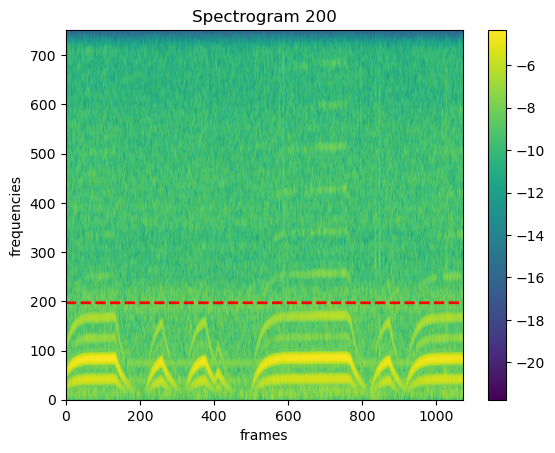

1000


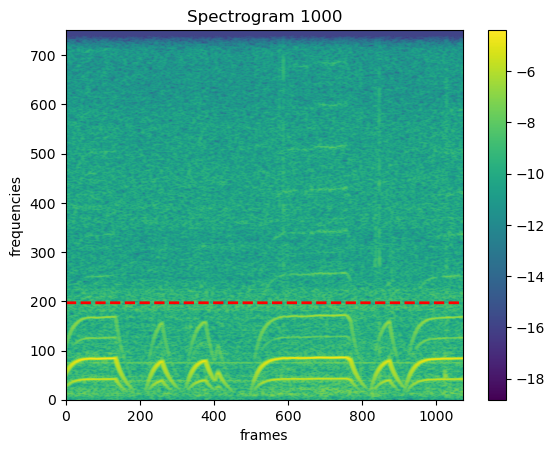

$\theta$


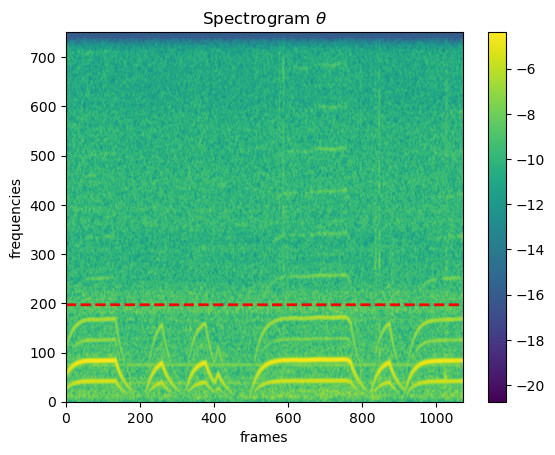

$\theta_t$


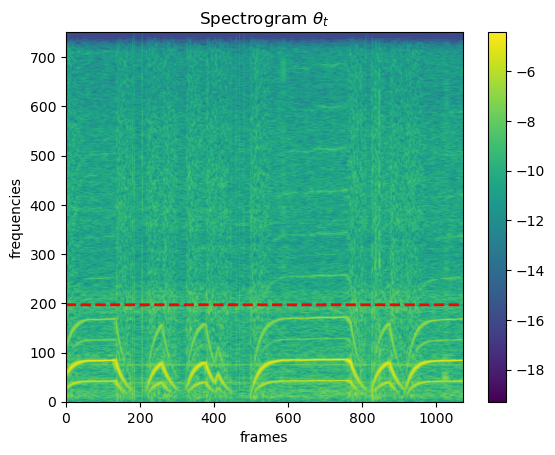

$\mathcal{R}_t$


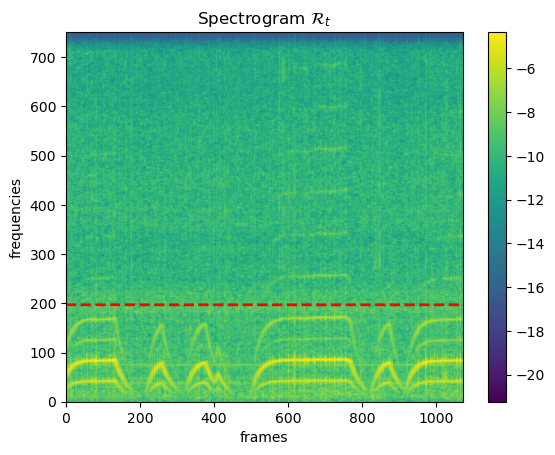

$\tilde{\theta}_t$


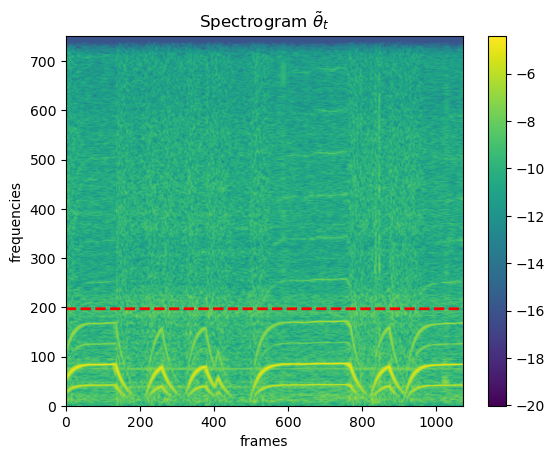

In [ ]:
with open("../fig/5_specs.pkl", "rb") as file: specs = pickle.load(file)
with open("../fig/5_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)

for key, out in f_hats.items(): 
    print(key)    
    plt.figure()
    plt.title(f'Spectrogram {key}')
    ax = plt.subplot()
    im = ax.imshow(specs[key][0].log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out.cpu(),  'r--', linewidth=2)
    plt.show()

200


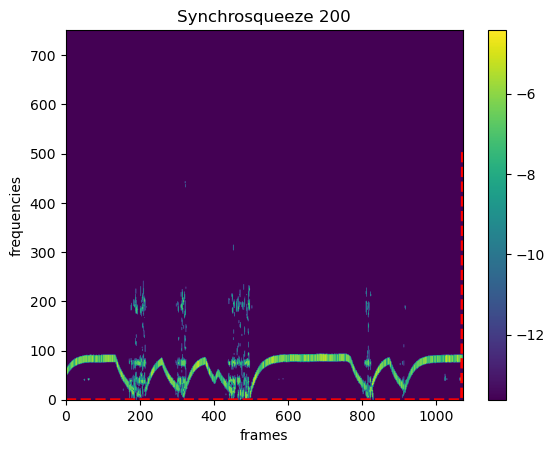

1000


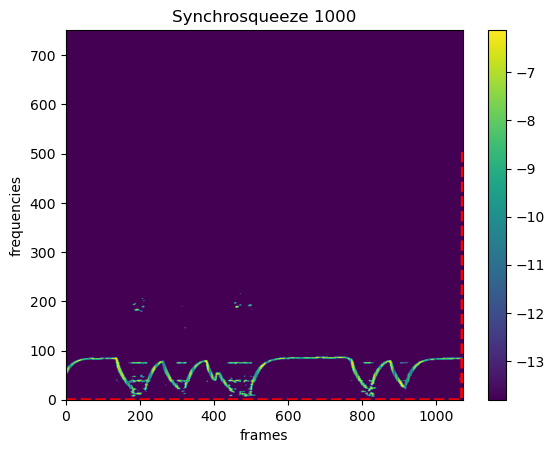

$\theta$


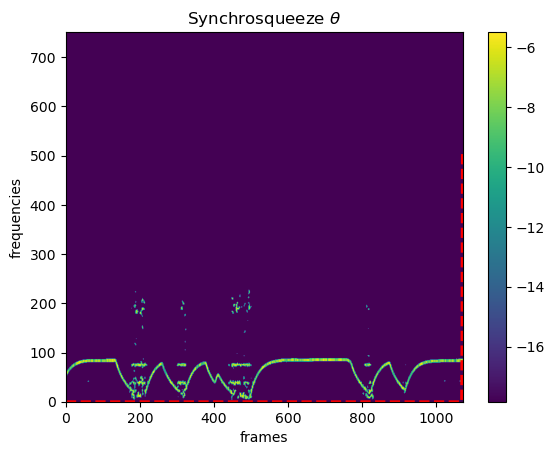

$\theta_t$


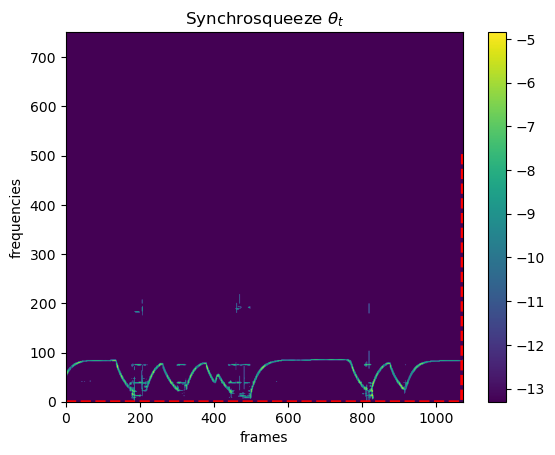

$\mathcal{R}_t$


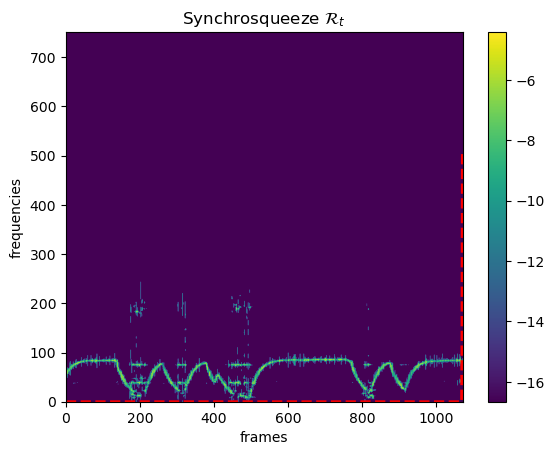

$\tilde{\theta}_t$


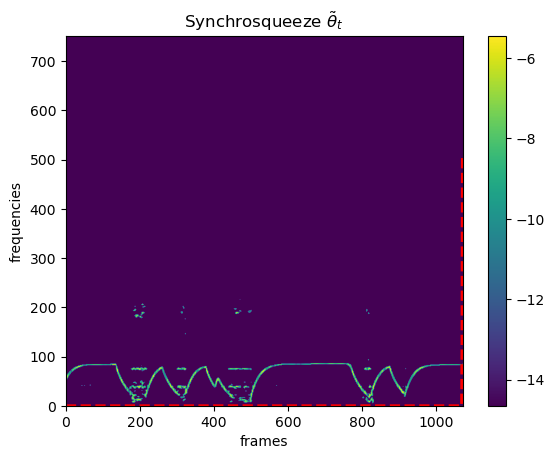

In [ ]:
with open("../fig/5_ss.pkl", "rb") as file: ss = pickle.load(file)
with open("../fig/5_f_hats2.pkl", "rb") as file: f_hats = pickle.load(file)

for key, out in f_hats.items(): 
    print(key)    
    plt.figure()
    plt.title(f'Synchrosqueeze {key}')
    ax = plt.subplot()
    im = ax.imshow(ss[key].log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,ss[key].shape[-1], 0, ss[key].shape[-2]])
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out.cpu(), 'r--', linewidth=2)
    plt.show()

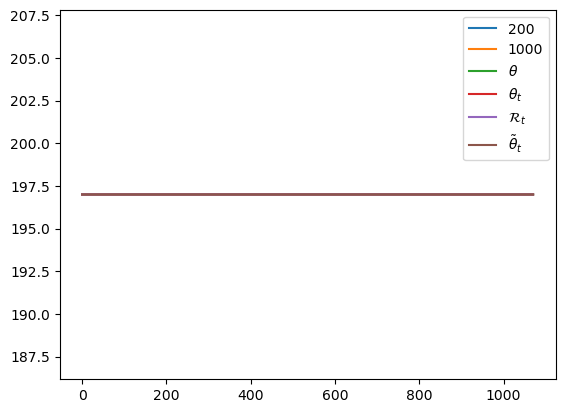

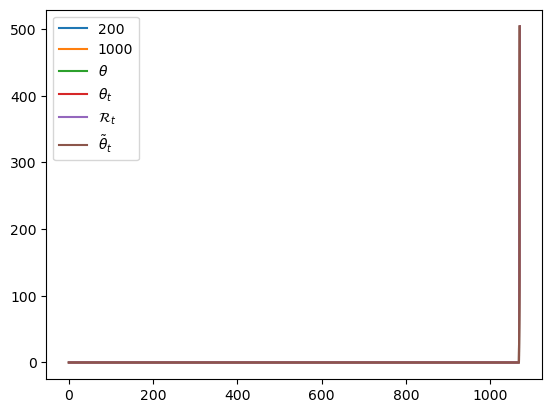

In [ ]:
with open("../fig/5_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)
for key, out in f_hats.items(): 
    plt.plot(out, label=key)
plt.legend()

plt.figure()
with open("../fig/5_f_hats2.pkl", "rb") as file: f_hats = pickle.load(file)
for key, out in f_hats.items(): 
    plt.plot(out, label=key)
plt.legend()